# Assignment 1-B

We have to fit various regression models to a dataset containing 547 samples, where the $i$-th sample is of the form:

$$ (x_1^{(i)}, x_2^{(i)}, y^{(i)}) $$

where $(x_1^{(i)}, x_2^{(i)})$ are the features and $y^{(i)}$ is the target value. 

In [1383]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from math import sqrt
from mpl_toolkits import mplot3d

In [1384]:
# data = pd.read_csv("fods_1.csv").to_numpy()
data = pd.read_csv("fods_1.csv")

We create a 80-20 split of the dataset for training and testing respectively.

In [1385]:
training_data = data.sample(frac = 0.8, random_state=1)
test_data = data.drop(training_data.index)

training_data = training_data.to_numpy()
test_data = test_data.to_numpy()

X_train = training_data[:, :2].T
Y_train = training_data[:,2].T

X_test = test_data[:,:2].T
Y_test = test_data[:,2].T

N_train = len(X_train[0])
N_test = len(X_test[0])

### Structure of matrices

Our feature matrix is stored as:

$$ X = \begin{pmatrix}
x_1^{(1)} & x_1^{(2)} & \ldots & x_1^{(N)}\\
x_2^{(1)} & x_2^{(2)} & \ldots & x_2^{(N)}
\end{pmatrix}_{2 \times N} $$

and the target vector is stored as:

$$ Y = \begin{pmatrix}
y^{(1)} & y^{(2)} & \ldots & y^{(N)}
\end{pmatrix}_{1 \times N}  $$



# POLYNOMIAL REGRESSION

### Our model

$$ f_{\textbf{w}}(\textbf{x}^{(i)}) = \sum_{j=0}^{M} w_jx_j^{(i)} $$

where $x_0^{(i)} = 1$ for all training examples, $x_1^{(i)}$ and $x_2^{(i)}$ correspond to the features in dataset and the remaining $x_j^{(i)}$'s refer to higher degree terms found by multiplying $x_1^{(i)}$ and $x_2^{(i)}$.

### Normalization

We calculate the mean ($\mu$) and standard deviation ($\sigma$) of the training data. We normalize training data as:

$$ x_j^{(i)} = \frac{x_j^{(i)} - \mu_j}{\sigma_j} $$

We also store $\mu$ and $\sigma$ vectors to normalize the testing data using the same $\mu$ and $\sigma$.

In [1386]:
def normalize_train(X):

    mean = np.array(np.mean(X[1:, :], axis = 1)).reshape([len(X) - 1, 1])
    std = np.array(np.std(X[1:, :], axis = 1)).reshape([len(X) - 1, 1])

    mean = np.concatenate((np.zeros([1,1]), mean), axis = 0)
    std = np.concatenate((np.ones([1,1]), std), axis = 0)

    mean_cur = np.repeat(mean, len(X[0]), axis = 1)
    std_cur = np.repeat(std, len(X[0]), axis = 1)

    X = (X - mean_cur) / std_cur
    return (X, mean, std)

In [1387]:
def normalize_test(X, mean, std):
    mean_cur = np.repeat(mean, len(X[0]), axis = 1)
    std_cur = np.repeat(std, len(X[0]), axis = 1)

    X = (X - mean_cur) / std_cur
    return X

### Generating Feature Matrix

We generate feature matrix for polynomial regression using nested for loops. We generate a matrix with all the polynomial features till degree 9, and later slice rows from this matrix to run polynomial regression for lower degrees.

Our generated feature matrix is as follows:

$$ \begin{pmatrix}
1 & 1 & \ldots & 1\\
x_1^{(1)} & x_1^{(2)} & \ldots & x_1^{(N)}\\
x_2^{(1)} & x_2^{(2)} & \ldots & x_2^{(N)}\\
(x_1^{(1)})^2 & (x_1^{(2)})^2 & \ldots & (x_1^{(N)})^2\\
(x_1^{(1)})(x_2^{(1)}) & (x_1^{(2)})(x_2^{(2)}) & \ldots & (x_1^{(N)})(x_2^{(N)})\\
(x_2^{(1)})^2 & (x_2^{(2)})^2 & \ldots & (x_2^{(N)})^2\\
\vdots & \vdots & & \vdots\\
(x_2^{(1)})^9 & (x_2^{(2)})^9 & \ldots & (x_2^{(N)})^9\\
\end{pmatrix} $$

In [1388]:
def generate_feature_matrix(X, deg):

    mat = np.ones([1,len(X[0])])
    for i in range (1, deg + 1):
        for j in range(i+1):
            k = i - j
            newRow = np.array((X[0]**k) * (X[1]**j)).reshape([1, len(X[0])])
            mat = np.concatenate((mat, newRow), axis = 0)
            
    return mat

### Cost Function

We calculate cost function for regression as follows:
$$ \begin{align*}
&J(\textbf{w}) = \frac{1}{2} \sum_{i=1}^N (y_{i} - f_{\textbf{w}}(\textbf{x}_{i}))^2 \\ \\
&J(\textbf{w}) = \frac{1}{2}\, (\textbf{Y} - \textbf{W}^{T}\,\textbf{X})\,(\textbf{Y} - \textbf{W}^{T}\,\textbf{X})^{T}
\end{align*}$$

In [1389]:
def cost_function(Y, X, W):
    return np.sum(1 / 2  * ((Y - W.T @ X) @ (Y - W.T @ X).T))

### Error Function
The error function will be the $RMS$ of the difference between the predicted value and the given value
$$ \begin{align*}
&E(\textbf{w}) = \sqrt{\frac{1}{N} \, \sum_{i=1}^N \, (y^{(i)} - f_{\textbf{w}}(\textbf{x}^{(i)}))^2} \\ \\
&E(\textbf{w}) = \sqrt{\frac{1}{N} \, (\textbf{Y} - \textbf{W}^{T}\,\textbf{X})\,(\textbf{Y} - \textbf{W}^{T}\,\textbf{X})^{T}}
\end{align*}$$


In [1390]:
def error_function(Y, X, W):
    mean_square = (1 / len(X[0])) * ((Y - W.T @ X) @ (Y - W.T @ X).T)[0][0]
    return sqrt(mean_square)

### Gradient Descent

We implement gradient descent by updating the weights for a fixed number of iterations:

$$ w_j = w_j - \alpha\frac{\partial J(\textbf{w})}{\partial w_j} $$

where $\alpha$ is the learning rate, and

$$ \frac{\partial J(\textbf{w})}{\partial w_j} = \sum_{i=1}^{N} (y^{(i)} - f_{\textbf{w}}(\textbf{x}^{(i)}))(-x_j^{(i)}) $$

Which in matrix form will be

$$ \begin{align*}

% &{\textbf{w}} = {\textbf{w}} - \alpha\frac{\partial J(\textbf{w})}{\partial \textbf{w}} \\ \\
&{\textbf{w}} = {\textbf{w}} - \alpha\,\,\frac{\mathrm{d}}{\mathrm{d} \textbf{w}} J(\textbf{w})\\ \\

&{\textbf{w}} = {\textbf{w}} - {\alpha} \, \textbf{X} \, ({\textbf{Y} - \textbf{w}^{T}\,\textbf{X}})^{T}

\end{align*}$$

In [1391]:
def gradient_descent(Y, X, W, alpha, iterations):
    
    N = len(X[0])
    # alpha /= 400
    cost = np.zeros(iterations)

    for i in range(iterations):
        W = W - (alpha)*((-X) @ (Y - W.T @ X).T)
        cost[i] = error_function(Y, X, W)
    
    return W, cost

### Stochastic Gradient Descent

We implement stochastic gradient descent similarly, the cost and its gradient is calculated with respect to a randomly chosed sample (instead of all samples) on every iteration.

$$ w_j = w_j - \alpha\,\frac{\partial J_{SGD}(\textbf{w})}{\partial w_j} $$

Cost function for SGD:

$$\begin{align*}

&J_{SGD}(\textbf{w}) = \frac{1}{2} (y^{(i)} - f_{\textbf{w}}(\textbf{x}^{(i)}))^2 \\ \\

&J_{SGD}(\textbf{w}) = \frac{1}{2} (y^{(i)} - \textbf{w}^{T}\,\textbf{x}^{(i)})\,(y^{(i)} - \textbf{w}^{T}\,\textbf{x}^{(i)})^{T}

\end{align*}$$

Gradient of cost function for SGD:

$$ \frac{\partial J_{SGD}(\textbf{w})}{\partial w_j} = (y^{(i)} - f_{\textbf{w}}(\textbf{x}^{(i)}))(-x_j^{(i)}) $$

$$ \frac{\mathrm{d}}{\mathrm{d} \mathrm{w}} J_{SGD}(\textbf{w}) = (-\textbf{x}^{(i)})(y^{(i)} - \textbf{w}^{T}\,\textbf{x}^{(i)}) $$

Finally Stochastic Gradient Descent looks like - 

$$ \textbf{w} = \textbf{w} - \alpha\,(-\textbf{x}^{(i)})(y^{(i)} - \textbf{w}^{T}\,\textbf{x}^{(i)}) $$


$i$ is chosen randomly from $(1, N)$ for every iteration.

In [1392]:
def stochastic_descent(Y, X, W, alpha, iterations):

    N = len(X[0])
    M = len(X)
    cost = np.zeros(iterations)
    # alpha /= N

    for i in range(iterations):

        index = random.randint(0, N - 1)
        Xi = X[:, index].reshape([M, 1])
        Yi = Y[index].reshape([1, 1])

        W = W - alpha * ((-Xi) @ (Yi - W.T @ Xi))
        cost[i] = error_function(Y, X, W)

    return W, cost

### Regression

The $\,\,training\_polynomial\_regression()$ function takes three parameters $-$ 

$ Y $ $-$ The target attribute matrix 

$ X $ $-$ The complete feature matrix 

$ descent\_type $ $-$ Specifies wether gradient descent or stochastic gradient descent has to be performed <br /> <br />

The function, iterates through degrees $0$ to $9$ and finds the weights $(W)$ by performing the appropriate descent on the given data.

The errors through each iteration is stored in $cost\_desc$ which is then plotted. The final errors for each degree is stored in $error\_history$

The final weights for each degree is stored in $W\_history$ which is returned along with $error\_history$

##### Getting the feature matrix for degree $d$
The feature matrix passed to the function, contains features upto degree $9$. The feature matrix is created in such a way that the first ${d + 2 \choose 2}$ rows of $X$, give the feature matrix for degree $d$


In [1393]:
def training_polynomial_regression(Y, X, descent_type):

    error_history = np.zeros([10, 1])
    W_history = []

    for i in range(10):

        count = (i + 1) * (i + 2) / 2
        count = int(count)

        _X = X[:count, :]
        W_desc = np.zeros([count, 1])

        iterations = 100000
        # iterations = 10000

        alpha = 0.0001

        W_desc, cost_desc = descent_type(Y, _X, W_desc, alpha, iterations)

        grad_descent_graph = np.array([i for i in range (len(cost_desc))])

        rounded_cost = float("{:.4f}".format(cost_desc[len(cost_desc) - 1]))

        error_history[i][0] = rounded_cost 

        W_history.append(W_desc.reshape([len(W_desc)]))

        plt.plot(grad_descent_graph, cost_desc)
    
    plt.show()

    return error_history, W_history

### Testing

The funcion $testing_polynomial_regression()$ takes $3$ arguments $-$

$Y$ $-$ The target attribute for the testing data

$X$ $-$ The complete feature matrix of the testing data

$W$ $-$ A ${2}$-d array. The $i^{th}$ row of which stores the weights for degree $i$ <br />


The final testing error of each degree is stored in $error\_history$ which is then returned by the function



In [1394]:
def testing_polynomial_regression(Y, X, W):

    error_history = np.zeros([10, 1])

    for i in range(10):

        count = (i + 1) * (i + 2) / 2
        count = int(count)
        _X = X[:count, :]
        
        error_history[i][0] = error_function(Y, _X, W[i])
    
    return error_history

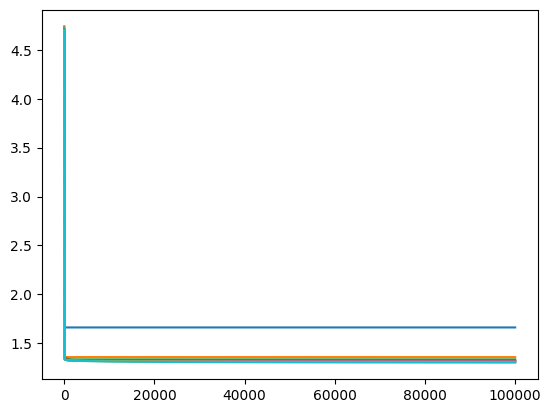

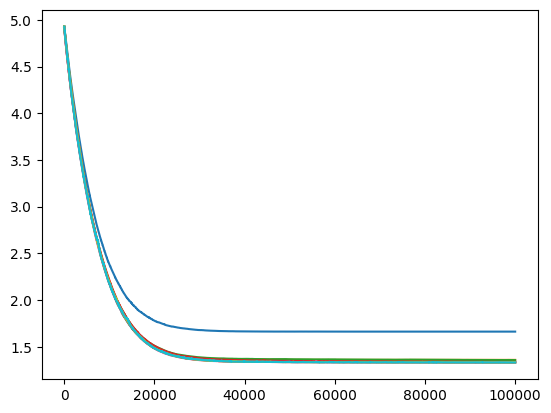

In [1395]:
X = generate_feature_matrix(X_train, 9)
(X, mean_norm, std_norm) = normalize_train(X)
training_error_gradient, W_gradient = training_polynomial_regression(Y_train, X, gradient_descent)
training_error_stochastic, W_stochastic = training_polynomial_regression(Y_train, X, stochastic_descent)

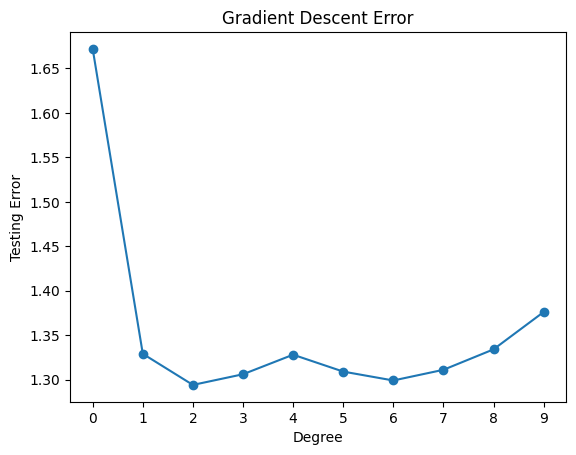

In [1396]:
X_grad_test = generate_feature_matrix(X_test, 9)
X_grad_test = normalize_test(X_grad_test, mean_norm, std_norm)

W_grad_mat = [i.reshape([len(i), 1]) for i in W_gradient]
testing_error_gradient = testing_polynomial_regression(Y_test, X_grad_test, W_grad_mat)

rounded_test_error_gradient = [float("{:.3f}".format(testing_error_gradient[i][0])) for i in range(10)]

plt.plot([i for i in range(10)], rounded_test_error_gradient, marker = 'o')
plt.xticks([i for i  in range(10)])
plt.xlabel("Degree")
plt.ylabel("Testing Error")
plt.title("Gradient Descent Error")
plt.show()

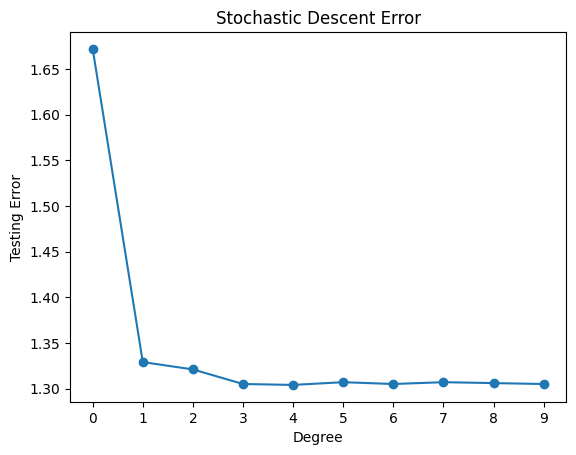

In [1397]:
X_stoc_test = generate_feature_matrix(X_test, 9)
X_stoc_test = normalize_test(X_stoc_test, mean_norm, std_norm)

W_stoc_mat = [i.reshape([len(i), 1]) for i in W_stochastic]
testing_error_stochastic = testing_polynomial_regression(Y_test, X_stoc_test, W_stoc_mat)

rounded_test_error_stochastic = [float("{:.3f}".format(testing_error_stochastic[i][0])) for i in range(10)]

plt.plot([i for i in range(10)], rounded_test_error_stochastic, marker = 'o')
plt.xticks([i for i  in range(10)])
plt.xlabel("Degree")
plt.ylabel("Testing Error")
plt.title("Stochastic Descent Error")
plt.show()

In [1398]:
degrees = np.array([i for i in range(10)]).reshape([10,1])
polynomial_regression_result = np.concatenate((degrees, training_error_gradient, training_error_stochastic, testing_error_gradient, testing_error_stochastic), axis = 1)

In [1399]:
polynomial_regression_table = pd.DataFrame(polynomial_regression_result, columns = ['Degree', 'Training Error (Gradient)', 'Training Error (Stochastic)','Testing Error (Gradient)', 'Testing Error (Stochastic)'])
polynomial_regression_table

,Degree,Training Error (Gradient),Training Error (Stochastic),Testing Error (Gradient),Testing Error (Stochastic)
0,0.0,1.6618,1.6618,1.671720,1.671665
1,1.0,1.3591,1.3591,1.328886,1.329437
2,2.0,1.3351,1.3568,1.293759,1.321292
3,3.0,1.3243,1.3376,1.306060,1.305240
4,4.0,1.3206,1.3321,1.328189,1.303759
5,5.0,1.3160,1.3326,1.308770,1.306589
6,6.0,1.3118,1.3324,1.299322,1.305460
7,7.0,1.3086,1.3325,1.310572,1.307109
8,8.0,1.3060,1.3315,1.334042,1.305757
9,9.0,1.3037,1.3313,1.376440,1.305394


# REGULARIZATION

### Regularized Cost Function

We calculate cost function for regularized linear regression as follows:

$$ J_{reg}(\textbf{w}) = \frac{1}{2} \sum_{i=1}^N (y^{(i)} - f_{\textbf{w}}(\textbf{x}^{(i)}))^2 + \frac{\lambda}{2} \sum_{j=1}^M |w_j|^q $$

The bias, $w_0$ is not regularized.

In [1400]:
def regularized_cost_function(Y, X, W, lam, q):

    cost1 = 0.5 * np.sum((Y - W.T @ X) ** 2)
    cost2 = (lam / 2) * np.sum(np.abs(W[1:]) ** q)

    return cost1 + cost2

### Regularized Linear Regression

We implement regularized linear regression by updating the weights for a fixed number of iterations:

$$ w_j = w_j - \alpha\frac{\partial J_{reg}(\textbf{w})}{\partial w_j} $$

where $\alpha$ is the learning rate, and

$$ \frac{\partial J_{reg}(\textbf{w})}{\partial w_j} = \sum_{i=1}^{N} (y^{(i)} - f_{\textbf{w}}(\textbf{x}^{(i)}))(-x_j^{(i)}) + \frac{\lambda}{2} q|w_j|^{q-1} $$

In [1401]:
# l = lambda
def regularized_gradient_descent(Y, X, W, q, alpha, l, iterations):
    N = X.shape[1]
    cost = np.zeros(iterations)
    # print(f"X: {X.shape}, N: {N}, Y: {Y.shape}, W: {W.shape}")
    for i in range(iterations):

        W = W - (alpha) * (((-X) @ (Y - W.T @ X).T) + ((l / 2) * q * (np.abs(W) ** (q - 1))))
        # cost[i] = regularized_cost_function(Y, X, W, l, q)
        cost[i] = error_function(Y,X,W)

    return W, cost

In [1402]:
# X_grad_test = normalize_test(X_grad_test, mean_norm, std_norm)

X_reg_train = np.concatenate((np.ones([1, len(X_train[0])]), X_train), axis = 0)
(X_reg_train, mean_reg, std_reg) = normalize_train(X_reg_train)
Y_reg_train = Y_train

X_reg_test = np.concatenate((np.ones([1, len(X_test[0])]), X_test), axis = 0)
X_reg_test = normalize_test(X_reg_test, mean_reg, std_reg)
Y_reg_test = Y_test

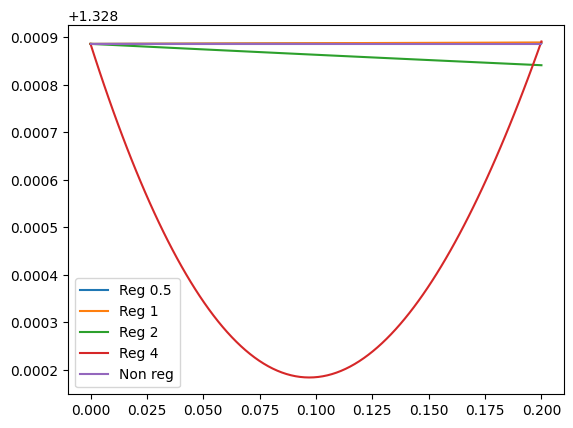

In [1403]:
q_vec = [0.5, 1, 2, 4]
lam_vec = np.linspace(0, 0.2, 100)
alpha = 0.0001
iterations = 1000

fig, ax = plt.subplots(1, 1)
for i in range(4):
    q = q_vec[i]
    cost_vec_reg = []
    for l in lam_vec:
        W_l_q = np.ones([3, 1])
        W_l_q, cost = regularized_gradient_descent(Y_reg_train, X_reg_train, W_l_q, q, alpha, l, iterations)
        # print(q, l, cost[-1])
        cost_vec_reg.append(error_function(Y_reg_test, X_reg_test, W_l_q))
    ax.plot(lam_vec, cost_vec_reg, label=f"Reg {q}")

ax.plot(lam_vec, np.ones(len(lam_vec)) * testing_error_gradient[1][-1], label=f"Non reg")

ax.legend()

plt.show()

In [1404]:
def predict(x1, x2, degree):
    X_p = []
    for i in range(degree+1):
        for j in range(i+1):
            k = i - j
            X_p.append(x1 ** j * x2 ** k)
    X_p = np.array(X_p).reshape(-1, 1)
    d = X_p.shape[0]
    X_p = (X_p - mean_norm[:d]) / std_norm[:d]
    return W_gradient[degree] @ X_p

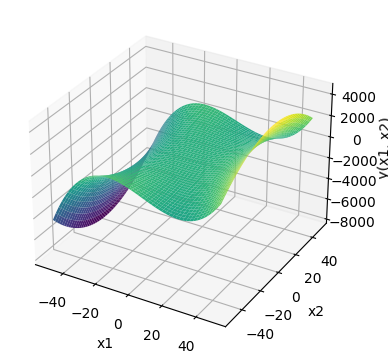

In [1405]:
from matplotlib import cm

fig = plt.figure(figsize=plt.figaspect(0.5))

ax = fig.add_subplot(1, 2, 1, projection='3d')

x1 = np.arange(-50, 50, 0.25)
x2 = np.arange(-50, 50, 0.25)
X1, X2 = np.meshgrid(x1, x2)
Z = np.zeros(X1.shape)
for i in range(Z.shape[0]):
    for j in range(Z.shape[1]):
        x1 = X1[i][j]
        x2 = X2[i][j]
        Z[i][j] = predict(x1, x2, 3)


surf = ax.plot_surface(X1, X2, Z, cmap=cm.viridis)

ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_zlabel("y(x1, x2)")
# fig.colorbar(surf, shrink=0.5, aspect=10)

plt.show()